# Import libraries and constants

# 1. Warmup

### Download the .xlsx table from :
http://www.nhl.com/stats/goalies?reportType=season&seasonFrom=20172018&seasonTo=20172018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set matplotlib parameters
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

In [ ]:
# set path for Excel file
GOALEES_PATH = "./storage/nhl_goalees.xlsx"
# parameter "thousands" parses commas separating thousands in Excel
goalees_df = pd.read_excel(GOALEES_PATH, thousands=",")
goalees_df.head()

In [ ]:
# Filter the original table to keep relevant column
# use .copy() to avoid modifying "goaless_df"
input_df = goalees_df[["Player", "GP", "GS", "Team", "SA", "Svs", "GA", "GAA"]].copy()
input_df.head()

In [ ]:
# compute saves ratio by dividing n Saves (Svs) by n Shots against (SA)
input_df["Svs_ratio"] = input_df["Svs"] / input_df["SA"]

In [ ]:
input_df = input_df.sort_values("Svs_ratio", ascending=False)

In [ ]:
# keep the first 20 rows (import to use "iloc", not "loc")
top20 = input_df.iloc[:20, :]
# rename the original index, reset the index, set the new index
top20 = top20.rename_axis("idx").reset_index().set_index("Player")
print(top20.shape)

## Plot top 20 goaltenders according to % shots saved

In [ ]:
#ylim manually sets the range of the bar plot
top20["Svs_ratio"].plot(kind="bar", title="Top 20 goaltenders by % Shots saved", ylabel="% Shots saved", ylim=(0.91, 0.939))

## Supplementary analysis
Do % Shots saved vary according to:
- the number of game played?
- the number of game started?
- the % of game started?

In [ ]:
# create binary column for top 20 players based on % Svs
input_df["is_top20"] = 0
input_df.loc[top20.idx, "is_top20"] = 1

In [ ]:
# ratio of game started
input_df["GS_ratio"] = input_df["GS"] / input_df["GP"]

In [ ]:
# reusable function to generate scatter plot
def scatter_x_by_y(df, x_col, y_col="Svs_ratio", conditional_col=None):
    plt.figure()

    # scatter plot using x_col and y_col
    plt.scatter(df[x_col], df[y_col])
    # if conditional_col is not None
    if conditional_col:
        # plot x_col and y_col where conditional_col==1 using color "C1"
        plt.scatter(df.loc[df[conditional_col]==1, x_col], df.loc[df[conditional_col]==1, y_col], color="C1")
    
    # set axis labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} by {x_col}")

    plt.show()

In [ ]:
scatter_x_by_y(input_df, "GS", conditional_col="is_top20")
scatter_x_by_y(input_df, "GP", conditional_col="is_top20")
scatter_x_by_y(input_df, "GS_ratio", conditional_col="is_top20")
scatter_x_by_y(input_df, "GAA", conditional_col="is_top20")

# API Query
https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md

### Game IDs
First 4 digits give the season (ie. 2017 for the 2017-2018 season)

Next 2 digits give the type of game
- 01 = preseason
- 02 = regular season
- 03 = playoffs
- 04 = all-star

Final 4 digits give the specific game number.
-  For regular season and preseason games, it ranges from 0001 to the number of games played. (1271 for seasons with 31 teams (2017 and onwards) and 1230 for seasons with 30 teams).
-  For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

In [1]:
import os
import requests
import json
import time

In [ ]:
# class to interact with the API
class ApiEngine():
    def __init__(self, storage_path):
        self.storage_path = storage_path
    
    # pass start_year, return a string to select a season (i.e., 2017 -> 20172018)
    def _start_year_to_season_string(self, start_year):
        return str(start_year) + str(start_year+1)
    
    # save the API JSON response to file
    def save_response(self, response, path, overwrite=False):
        if overwrite:
            with open(path, "w") as file:
                # if overwrite is true, return to beginning of file and overwrite
                file.seek(0)
                file.truncate()
                json.dump(response, file)
            return
        
        with open(path, "w") as file:
            json.dump(response, file)
    
    # query API endpoint
    def query_api(self, endpoint, params=None):
        # base url of the API
        url = f"https://statsapi.web.nhl.com/api/v1/{endpoint}"
        r = requests.get(url, params=params, timeout=3)
        # check if the HTTP request is valid
        try:
            r.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Could not reach API endpoint:\n'{url}'")
        return r.json()
    
    # query API for the schedule of the year (to get valid gamePk)
    def get_season_schedule(self, start_year):
        season_string = self._start_year_to_season_string(start_year)
        season_response = self.query_api("schedule", params={"season": season_string})
        save_path = f"{self.storage_path}/schedule/schedule_{season_string}.json"
        self.save_response(season_response, save_path, overwrite=False)
        
    # query API for a specific game
    def get_game(self, gamePk):
        game_response = self.query_api(f"game/{gamePk}/feed/live")
        season = game_response["gameData"]["game"]["season"]
        save_path = f"{self.storage_path}/games/{season}/game_{season}_{gamePk}.json"
        self.save_response(game_response, save_path, overwrite=False)
    
    # loop to query all games of a season
    def get_all_season_games(self, start_year):
        season_schedule = self.get_season_schedule(start_year)
        
        for date in season_schedule["dates"]:
            for game in date["games"]:
                self.get_game(game["gamePk"])
                time.sleep(3) # delay to avoid spamming requests

In [2]:
# class to interact with the stored JSON files
class StorageEngine():
    def __init__(self, storage_path):
        self.storage_path = storage_path
        
    def _start_year_to_season_string(self, start_year):
        return str(start_year) + str(start_year+1)
    
    # load season schedule JSON
    def get_season_schedule(self, start_year):
        season_string = self._start_year_to_season_string(start_year)
        save_path = f"{self.storage_path}/schedule/schedule_{season_string}.json"
        with open(save_path, "r") as file:
            return json.load(file)
    
    # load game JSON
    def get_game(self, start_year, gamePk):
        season_string = self._start_year_to_season_string(start_year)
        save_path = f"{self.storage_path}/games/{season_string}/game_{season_string}_{gamePk}.json"
        with open(save_path, "r") as file:
            return json.load(file)
    
    # get list of valid gamePk from season schedule
    def get_all_season_gamePk(self, start_year):
        season_schedule = self.get_season_schedule(start_year)

        gamePk_list = []
        for date in season_schedule["dates"]:
            for game in date["games"]:
                gamePk_list.append(game["gamePk"])
        return gamePk_list

# Visualizing JSON data

In [4]:
import pandas as pd
from ipywidgets import interact, SelectionSlider

In [5]:
@interact(start_year=[2016, 2017, 2018, 2019])
def view_season(start_year=2016):
    # load engine
    storage_engine = StorageEngine("./data/raw")
    # load list of all gamePk for selected season
    gamePk_list = storage_engine.get_all_season_gamePk(start_year)
            
    @interact(game_idx=(0, len(gamePk_list)-1, 1))
    def view_games(game_idx=0):
        # load the game for the (season, gamePk) selected
        game_json = storage_engine.get_game(start_year, gamePk_list[game_idx])
        
        # function to specify the data to display
        def _print_metadata(game_json):
            season = game_json["gameData"]["game"]["season"]
            gamePk = game_json["gamePk"]
            game_type = game_json["gameData"]["game"]["type"]
            start_time = game_json["gameData"]["datetime"]["dateTime"]
            venue = game_json["gameData"]["venue"]["name"]
            
            home_tri = game_json["gameData"]["teams"]["home"]["triCode"]
            away_tri = game_json["gameData"]["teams"]["away"]["triCode"]
            
            print("season:\t", season)
            print("gamePk:\t", gamePk)
            print("game_type:\t", game_type)
            print("start_time:\t", start_time)
            print("venue:\t", venue)
            print(f"{home_tri} (home) vs. {away_tri} (away)")
        
        _print_metadata(game_json)    
            
    view_games()

interactive(children=(Dropdown(description='start_year', options=(2016, 2017, 2018, 2019), value=2016), Output…

season:	 20162017
gamePk:	 2016010002
game_type:	 PR
start_time:	 2016-09-25T17:00:00Z
venue:	 Scottrade Center
STL (home) vs. CBJ (away)


# Tidy data
Convert JSON to pandas.DataFrame

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from src.game_model import game_json_to_metadata_dict
from src.plays_model import game_json_to_plays_list

In [ ]:
#TODO
# NOT FULLY IMPLEMENTED
def get_season_metadata(start_year):
    storage_engine = StorageEngine("./data/raw")
    gamePk_list = storage_engine.get_all_season_gamePk(start_year)

    metadata_records = []

    for gamePk in gamePk_list:
        print(gamePk)
        game_json = storage_engine.get_game(start_year, gamePk)
        metadata_dict = game_json_to_metadata_dict(game_json)
        metadata_records.append(metadata_dict)
        
    return pd.DataFrame.from_records(metadata_records)

In [7]:
def get_season_plays_df(start_year):
    storage_engine = StorageEngine("./data/raw")
    gamePk_list = storage_engine.get_all_season_gamePk(start_year)

    game_plays_df_list = []
    for gamePk in gamePk_list:
        game_json = storage_engine.get_game(start_year, gamePk)
        game_plays_df = pd.DataFrame.from_records(game_json_to_plays_list(game_json))
        game_plays_df_list.append(game_plays_df)
    
    season_plays_df = pd.concat(game_plays_df_list)
        
    return season_plays_df

def preprocess_season_plays(start_year):
    season_plays_df = get_season_plays_df(start_year)
    season_plays_df.to_csv(f"./data/processed/season_plays_{start_year}.csv", index=False)

In [8]:
#preprocess_season_plays(2016)

KeyboardInterrupt: 

# Simple visualization

In [52]:
import pandas as pd
from ipywidgets import interact
import plotly.express as px
import plotly.graph_objects as go

In [58]:
season_plays_df = pd.read_csv("./data/processed/season_plays_2016.csv", index_col=False)
#season_plays_df = season_plays_df.drop(columns="Unnamed: 0")
season_plays_df.head()

,event_idx,event_type_id,period_idx,period_type,game_time,shot_type,team_initiative_id,team_initiative_name,x_coord,y_coord,...,goalie_name,strength,empty_net_bool,gamePk,game_season,game_type,game_start_time,venue,home_team,away_team
0,53,SHOT,1,REGULAR,2016-09-25T17:09:01Z,Wrist Shot,CBJ,Columbus Blue Jackets,40.0,-25.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
1,58,SHOT,1,REGULAR,2016-09-25T17:13:53Z,Backhand,CBJ,Columbus Blue Jackets,82.0,5.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
2,62,SHOT,1,REGULAR,2016-09-25T17:15:16Z,Wrist Shot,STL,St. Louis Blues,-65.0,-14.0,...,Joonas Korpisalo,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
3,63,SHOT,1,REGULAR,2016-09-25T17:15:30Z,Wrist Shot,CBJ,Columbus Blue Jackets,8.0,25.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
4,67,SHOT,1,REGULAR,2016-09-25T17:17:55Z,Wrist Shot,CBJ,Columbus Blue Jackets,63.0,19.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ


## Fig 5.1

In [ ]:
shots_freq = season_plays_df["shot_type"].value_counts()
shots_stats = season_plays_df.groupby(["shot_type", "event_type_id"]).size()
shots_ratio = shots_stats[(slice(None), "GOAL")] / shots_freq

In [ ]:
fig = px.bar(
    shots_stats,
    x=shots_freq.index,
    y=shots_freq,
    text=shots_ratio.round(2),
    title="Frequency of shot types across teams - Season 2016-2017",
    barmode="group")

fig.update_layout(
    xaxis=dict(title="Shot type"),
    yaxis=dict(title="Frequency"),
)

fig.show()

## Fig 5.2

In [8]:
# the dimensions of the NHL ice rink are 200' long x 85' wide
# x coordinates range between -98 and 98 (the sign indicate which team's side)
# y coordinates range between -42 and 42
# the goal is align with y=0, and 11' away from the rink
# the x coordinates is the given by 11/100 * 98 = 10.78
season_plays_df.head()

,event_idx,event_type_id,period_idx,period_type,game_time,shot_type,team_initiative_id,team_initiative_name,x_coord,y_coord,...,goalie_name,strength,empty_net_bool,gamePk,game_season,game_type,game_start_time,venue,home_team,away_team
0,53,SHOT,1,REGULAR,2016-09-25T17:09:01Z,Wrist Shot,CBJ,Columbus Blue Jackets,40.0,-25.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
1,58,SHOT,1,REGULAR,2016-09-25T17:13:53Z,Backhand,CBJ,Columbus Blue Jackets,82.0,5.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
2,62,SHOT,1,REGULAR,2016-09-25T17:15:16Z,Wrist Shot,STL,St. Louis Blues,-65.0,-14.0,...,Joonas Korpisalo,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
3,63,SHOT,1,REGULAR,2016-09-25T17:15:30Z,Wrist Shot,CBJ,Columbus Blue Jackets,8.0,25.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ
4,67,SHOT,1,REGULAR,2016-09-25T17:17:55Z,Wrist Shot,CBJ,Columbus Blue Jackets,63.0,19.0,...,Jake Allen,NaN,NaN,2016010002,20162017,PR,2016-09-25T17:00:00Z,Scottrade Center,STL,CBJ


In [9]:
def dist_from_goal(df):
    return np.sqrt((10.78 - df["x_coord"])**2 + df["y_coord"]**2)

In [ ]:
season_plays_df["dist_from_goal"] = dist_from_goal(season_plays_df)

In [101]:
def explore_shots(plays_df):
    @interact(
        gamePk=SelectionSlider(options=season_plays_df["gamePk"].unique()),
        period_idx=SelectionSlider(options=[1, 2, 3, 4, 5]),
    )
    def plot_shots_from_game_period(gamePk, period_idx):
        game_df = plays_df.loc[plays_df["gamePk"]==gamePk]
        game_df["team_initiative_id"] = game_df["team_initiative_id"].astype("category")
        
        ax = game_df.loc[game_df["period_idx"].isin([period_idx])].plot.scatter(x="x_coord", y="y_coord", c="team_initiative_id", cmap="RdBu")
        ax.set_xlim(-100, 100)
        ax.set_ylim(-44, 44)
    
explore_shots(season_plays_df)

interactive(children=(SelectionSlider(description='gamePk', options=(2016010002, 2016010001, 2016010004, 20160…

## Fig 6

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

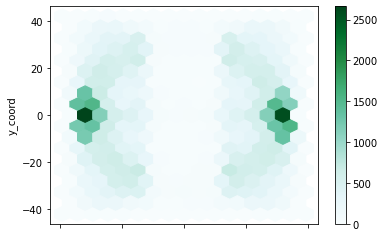

In [70]:
season_plays_df.plot.hexbin(x="x_coord", y="y_coord", gridsize=16)